In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
%matplotlib inline

In [23]:
train_data=pd.read_csv(r'C:\Users\anike\jupyter_code\Semester 5 Minor Project\tweet-sentiment-extraction\train.csv',header=0)
test_data=pd.read_csv(r'C:\Users\anike\jupyter_code\Semester 5 Minor Project\tweet-sentiment-extraction\test.csv',header=0)

In [25]:
data=pd.concat([train_data[['text','sentiment']],test_data[['text','sentiment']]],axis=0)
data.dropna()
data['text']=data['text'].astype(str)
data.describe()

,text,sentiment
count,31015,31015
unique,31015,3
top,"I`d have responded, if I were going",neutral
freq,1,12548


In [27]:
'''
EXPLORATORY DATA ANALYSIS : 
- Checking class distribution
- Text length distribution
- WordCloud
'''
def eda(df):
    # CLASS DISTRIBUTION
    print("Class Distribution :\n")
    print(df['sentiment'].value_counts())
    print("\n\n")
    sns.countplot(x='sentiment',data=df)
    plt.title("Class Distribution")
    plt.show()
    print("\n\n")
    
    # TEXT LENGTH DISTRIBUTION
    df['text_length'] = df['text'].apply(lambda x: len(x.split()))
    sns.histplot(df['text_length'], bins=50, kde=True)
    plt.title("Text Length Distribution")
    plt.show()
    print("\n\n")
    
    # CLASSWISE WORDCLOUD
    color_palettes=['magma','viridis','inferno']
    color_idx=0
    for x in df['sentiment'].unique():
        subset=df[df['sentiment']==x]
        text=" ".join(subset['text'])
        wordcloud = WordCloud(width=800, height=400, background_color='white',colormap=color_palettes[color_idx]).generate(text)
        color_idx+=1
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Wordcloud for {x} class",fontsize=25,fontweight='bold')
        plt.axis("off") #hides axis lines from wordcloud
        plt.show()
        print()

In [29]:
'''
preprocessing text or cleaning text
- lowercasing
- replacement of URL's and numbers with placeholders
- handling of punctuation
'''
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'(?i)http\S+|www\S+|https\S+', '<URL>', text, flags=re.IGNORECASE|re.MULTILINE)
    text = re.sub(r'\d+', '<NUM>', text)
    text = re.sub(r'!', ' <EXCLAMATION> ', text)
    text = re.sub(r'\?', ' <QUESTION> ', text)
    text = re.sub(r'\.\.\.', ' <ELLIPSIS> ', text)
    text = re.sub(r'[^\w\s<EXCLAMATION><QUESTION><ELLIPSIS><URL><NUM>]', '', text) # removes punctuation and special characters except the mentioned placeholders
    return text

In [31]:
'''
Preprocesses the dataset for model input:
    - Applies `preprocess_text` to data and creates clean data
    - Encodes target labels
    - Tokenizes and pads text sequences
'''
def preprocess_data(df,num_words,maxlen):
    # TEXT PREPROCESSING
    df['clean_text']=df['text'].apply(preprocess_text)
    # LABEL ENCODING OF SENTIMENT CLASSES
    labelencoder=LabelEncoder()
    df['encoded_class']=labelencoder.fit_transform(df['sentiment'])
    # TOKENIZING TEXT & GETTING SEQUENCES
    tokenizer=Tokenizer(num_words=num_words,oov_token="<OOV>")
    tokenizer.fit_on_texts(df['clean_text'])
    sequences=tokenizer.texts_to_sequences(df['clean_text'])
    # PADDING SEQUENCES
    padded_sequences=pad_sequences(sequences,maxlen=maxlen,padding='post',truncating='post')
    return padded_sequences,df['encoded_class'],tokenizer


In [33]:
# LSTM
def tunable_lstm(embedding_dim=128,units=64,dropout=0.2,optimizer='adam'):
    model = Sequential([
        Embedding(input_dim=17000, output_dim=embedding_dim, input_length=100),
        LSTM(units, return_sequences=False),
        Dropout(rate=dropout),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [37]:
# STARTING MAIN CODE

Class Distribution :

sentiment
neutral     12548
positive     9685
negative     8782
Name: count, dtype: int64





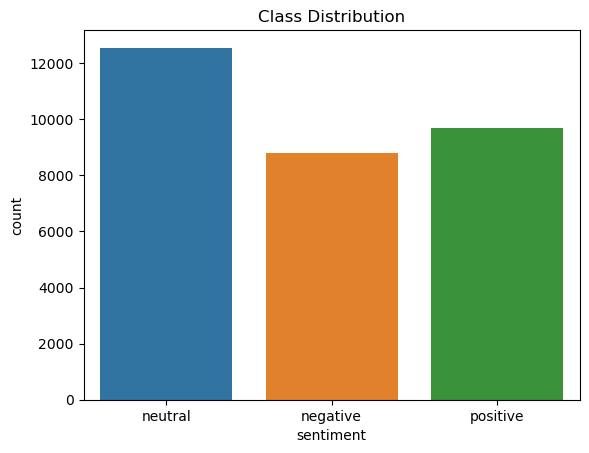

C:\Users\anike\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


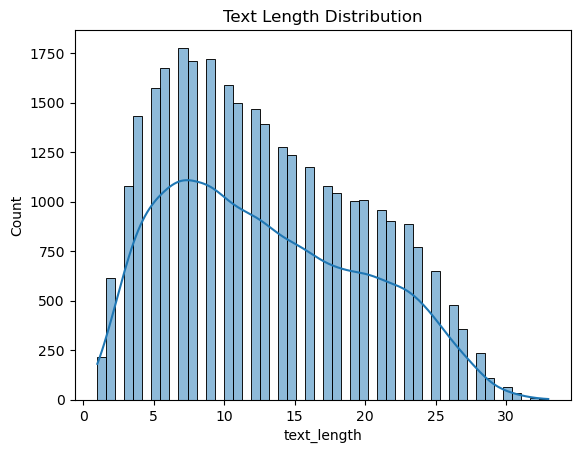

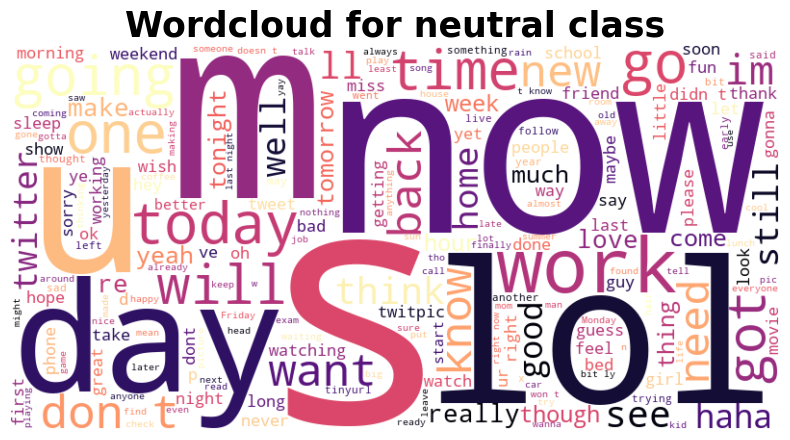

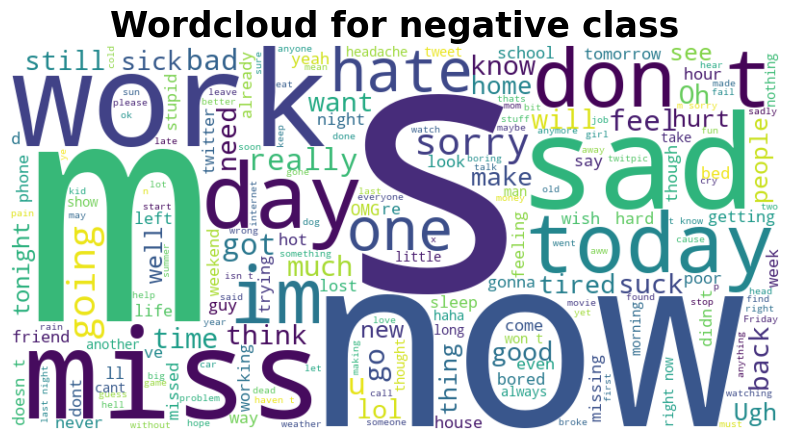

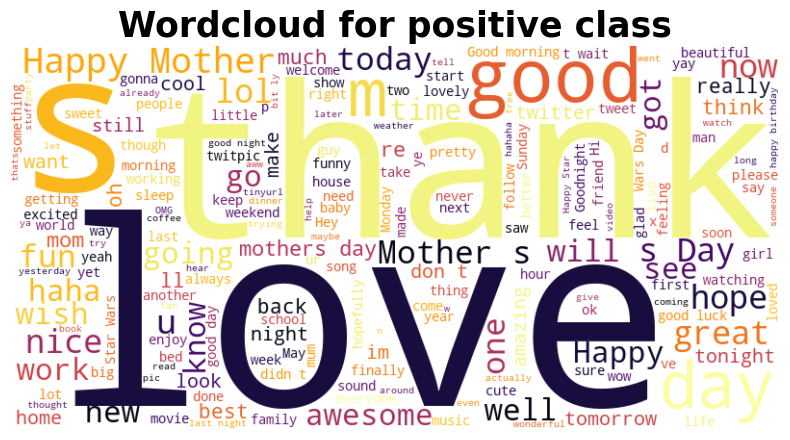

In [39]:
eda(data)

In [35]:
# HYPERPARAMETERS FOR TOKENIZATION
num_words = 17000
maxlen_grid = [50, 100, 150]

In [37]:
#INITIALIZING BEST  TOKENIZATION CONFIGURATION VARIABLES
best_num_words, best_maxlen = 17000, 100
best_accuracy = 0

In [ ]:
# HYPERPARAMETER TUNING FOR TOKENIZATION USING 2 FOR LOOPS
for y in maxlen_grid:
    padded_sequences,labels,tokenizer=preprocess_data(data,num_words=num_words,maxlen=y)
    x_train,x_test,y_train,y_test=train_test_split(padded_sequences,labels,test_size=0.2,random_state=33)
    base_model=tunable_lstm()
    base_model.fit(x_train,y_train,epochs=2,batch_size=64,verbose=0)
    y_pred=np.argmax(base_model.predict(x_test),axis=-1)
    accuracy=accuracy_score(y_test,y_pred)
    if accuracy>best_accuracy:
        best_num_words,best_maxlen=num_words,y
        best_accuracy=accuracy
print(f"\nBest Tokenization configuration : num_words={best_num_words}, maxlen={best_maxlen}")

In [109]:
# Preprocessing Data with Best Parameters
padded_sequences, labels, tokenizer = preprocess_data(data, num_words=best_num_words, maxlen=best_maxlen)
x_train,x_test,y_train,y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=33)

In [110]:
# LSTM MODEL
model_lstm = Sequential([
    Embedding(input_dim=17000, output_dim=128, input_length=50),
    LSTM(units=64, return_sequences=False),
    Dropout(rate=0.2),
    Dense(3, activation='softmax')
])
model_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\anike\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [111]:
# LSTM MODEL TRAINING and VALIDATION
earlystopping=EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
model_lstm.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),epochs=6,batch_size=32)

Epoch 1/6
776/776 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.3991 - loss: 1.0891 - val_accuracy: 0.4059 - val_loss: 1.0860
Epoch 2/6
776/776 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4109 - loss: 1.0859 - val_accuracy: 0.4059 - val_loss: 1.0864
Epoch 3/6
776/776 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4222 - loss: 1.0674 - val_accuracy: 0.5602 - val_loss: 0.8707
Epoch 4/6
776/776 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5891 - loss: 0.8172 - val_accuracy: 0.6774 - val_loss: 0.7531
Epoch 5/6
776/776 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7260 - loss: 0.6531 - val_accuracy: 0.7064 - val_loss: 0.7000
Epoch 6/6
776/776 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7832 - loss: 0.5608 - val_accuracy: 0.7109 - val_loss: 0.7062


In [ ]:
# for od in [32,64,128]:
#     for il in [50,100]:
#         for units in [32,64]:
#             for d in [0.1,0.2,0.5]:
#                 model_lstm = Sequential([
#                     Embedding(input_dim=17000, output_dim=od, input_length=il),
#                     LSTM(units=units, return_sequences=False),
#                     Dropout(rate=d),
#                     Dense(3, activation='softmax')
#                 ])
#                 model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#                 earlystopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
#                 history=model_lstm.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),epochs=10,batch_size=32)

#                 val_acc = history.history['val_accuracy'][-1]
#                 if val_acc > best_val_acc:
#                     best_config = {
#                                     'Batch Size': bsize,
#                                     'dense': dense,
#                                     'Optimizer': optimizer,
#                                     'd1': d1,
#                                     'ks':ks,
#                                     'filters':filters,
#                                     'outputdimension':od,
#                                     'Validation Accuracy': val_acc
#                                 }
#                     best_val_acc = val_acc
#                     for x in best_config:
#                         print(best_config[x])

In [17]:
# for x in best_config:
#     print(best_config[x])

In [74]:
# CNN Model
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=17000, output_dim=128, input_length=50))
model_cnn.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dropout(0.6))
model_cnn.add(Dense(3, activation='softmax'))
                            
model_cnn.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
earlystopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
model_cnn.fit(x=x_train,y=y_train,validation_data=[x_test,y_test],epochs=8,batch_size=128,callbacks=[earlystopping])


Epoch 1/8


C:\Users\anike\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4225 - loss: 1.0691 - val_accuracy: 0.5683 - val_loss: 0.8858
Epoch 2/8
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5911 - loss: 0.8852 - val_accuracy: 0.7027 - val_loss: 0.7357
Epoch 3/8
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6802 - loss: 0.7627 - val_accuracy: 0.7277 - val_loss: 0.6742
Epoch 4/8
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7185 - loss: 0.6809 - val_accuracy: 0.7305 - val_loss: 0.6543
Epoch 5/8
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7422 - loss: 0.6298 - val_accuracy: 0.7348 - val_loss: 0.6433
Epoch 6/8
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7638 - loss: 0.5815 - val_accuracy: 0.7343 - val_loss: 0.6413
Epoch 7/8
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7820 - loss: 0.5492 - val_accuracy: 0.7293 - val_loss: 0.6479
Epoch 8/8
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7968 - loss: 0.4996 - val_accuracy: 0.7335 - val_loss: 

In [59]:
# # HYPERPARAMETER TUNING FOR CNN
# results={}
# best_config = None
# best_val_acc = 0
# for od in [64,128]:
#     for filters in [32,64,128]:
#         for dense in [16,32,64]:
#             for bsize in [32,128]:
#                             model_cnn = Sequential()
        
#                                 # Embedding layer
#                             model_cnn.add(Embedding(input_dim=17000, output_dim=od, input_length=50))
                                
#                                 # Convolutional layer
#                             model_cnn.add(Conv1D(filters=filters, kernel_size=5, activation='relu'))
                                
#                                 # GlobalMaxPooling layer
#                             model_cnn.add(GlobalMaxPooling1D())
                                
#                                 # Dropout for regularization
#                             model_cnn.add(Dropout(0.2))
                                
#                                 # Dense hidden layer
#                             model_cnn.add(Dense(dense, activation='relu'))
                                
#                                 # Dropout for additional regularization
#                             model_cnn.add(Dropout(0.6))
                                
#                                 # Output layer with softmax activation for multiclass classification
#                             model_cnn.add(Dense(3, activation='softmax'))
                            
#                             model_cnn.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
#                             earlystopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
#                             history=model_cnn.fit(x=x_train,y=y_train,validation_data=[x_test,y_test],epochs=10,batch_size=bsize,callbacks=[earlystopping])

#                             val_acc = history.history['val_accuracy'][-1]
#                             if val_acc > best_val_acc:
#                                 best_config = {
#                                     'Batch Size': bsize,
#                                     'dense': dense,
#                                     'Optimizer': optimizer,
#                                     'd1': d1,
#                                     'ks':ks,
#                                     'filters':filters,
#                                     'outputdimension':od,
#                                     'Validation Accuracy': val_acc
#                                 }
#                                 best_val_acc = val_acc
#                                 for x in best_config:
#                                     print(best_config[x])
                                

# print("Best Configuration:")
# for key, value in best_config.items():
#     print(f"{key}: {value}")

In [115]:
# Evaluate both models and compare
print("\nEvaluating LSTM Model...")
y_pred_lstm = np.argmax(model_lstm.predict(x_test), axis=-1)
lstm_accuracy = accuracy_score(y_test, y_pred_lstm)
print(f"LSTM Validation Accuracy: {lstm_accuracy}")
print(classification_report(y_test, y_pred_lstm, target_names=['negative', 'neutral', 'positive']))

print("\nEvaluating CNN Model...")
y_pred_cnn = np.argmax(model_cnn.predict(x_test), axis=-1)
cnn_accuracy = accuracy_score(y_test, y_pred_cnn)
print(f"CNN Validation Accuracy: {cnn_accuracy}")
print(classification_report(y_test, y_pred_cnn, target_names=['negative', 'neutral', 'positive']))

# Compare accuracies and report the best model
if lstm_accuracy > cnn_accuracy:
    print("\nLSTM performed better.")
else:
    print("\nCNN performed better.")



Evaluating LSTM Model...
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM Validation Accuracy: 0.7109463162985652
              precision    recall  f1-score   support

    negative       0.74      0.63      0.68      1728
     neutral       0.64      0.75      0.69      2517
    positive       0.79      0.73      0.76      1958

    accuracy                           0.71      6203
   macro avg       0.73      0.70      0.71      6203
weighted avg       0.72      0.71      0.71      6203


Evaluating CNN Model...
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
CNN Validation Accuracy: 0.7343221022086087
              precision    recall  f1-score   support

    negative       0.72      0.72      0.72      1728
     neutral       0.69      0.72      0.71      2517
    positive       0.81      0.77      0.79      1958

    accuracy                           0.73      6203
   macro avg       0.74      0.73      0.74      6203
weighted avg       0.74      0.73      0.73      6203


CNN performed b